In [1]:
import argparse
import os
import pickle
import time
from itertools import product
from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb

import numpy as np

from tqdm.auto import tqdm

from dynamics import prior, disturbance, plant
from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef)

from functools import partial
import matplotlib.pyplot as plt

In [2]:
def convert_p_qbar(p):
    return np.sqrt(1/(1 - 1/p) - 1.1)

def convert_qbar_p(qbar):
    return 1/(1 - 1/(1.1 + qbar**2))

In [3]:
# Support functions for generating loop reference trajectory
def reference(t):
    T = 10.            # loop period
    d = 4.             # displacement along `x` from `t=0` to `t=T`
    w = 4.             # loop width
    h = 6.             # loop height
    ϕ_max = jnp.pi/3   # maximum roll angle (achieved at top of loop)

    x = (w/2)*jnp.sin(2*jnp.pi * t/T) + d*(t/T)
    y = (h/2)*(1 - jnp.cos(2*jnp.pi * t/T))
    ϕ = 4*ϕ_max*(t/T)*(1-t/T)
    r = jnp.array([x, y, ϕ])
    return r

def ref_derivatives(t):
    ref_vel = jax.jacfwd(reference)
    ref_acc = jax.jacfwd(ref_vel)
    r = reference(t)
    dr = ref_vel(t)
    ddr = ref_acc(t)
    return r, dr, ddr

def controller(q, dq, r, dr, ddr, f_hat, NF_ctrl_param):
    Lam, K = NF_ctrl_param['Lam'], NF_ctrl_param['K']
    e, de = q - r, dq - dr
    s = de + Lam @ e
    v, dv = dr - Lam @ e, ddr - Lam @ de

    H, C, g, B = prior(q, dq)
    tau = H@dv + C@v + g - f_hat - K@s
    u = jnp.linalg.solve(B, tau)
    return u

def disturbance(q, dq, w):
    # Original implementation   
    β = jnp.asarray((0.1, 1.))
    ϕ, dx, dy = q[2], dq[0], dq[1]
    sinϕ, cosϕ = jnp.sin(ϕ), jnp.cos(ϕ)
    R = jnp.array([
        [cosϕ, -sinϕ],
        [sinϕ,  cosϕ]
    ])
    v = R.T @ jnp.array([dx - w, dy])
    f_ext = - jnp.array([*(R @ (β * v * jnp.abs(v))), 0.])
    return f_ext

In [4]:
def diagnose_simulate(ts, w, params, reference,
                plant=plant, prior=prior, disturbance=disturbance, NGD_flag=False):
    """TODO: docstring."""
    # Required derivatives of the reference trajectory
    def ref_derivatives(t):
        ref_vel = jax.jacfwd(reference)
        ref_acc = jax.jacfwd(ref_vel)
        r = reference(t)
        dr = ref_vel(t)
        ddr = ref_acc(t)
        return r, dr, ddr

    # Adaptation law
    def adaptation_law(q, dq, r, dr, params=params, NGD_flag=NGD_flag):
        # Regressor features
        y = jnp.concatenate((q, dq))
        for W, b in zip(params['W'], params['b']):
            y = jnp.tanh(W@y + b)

        # Auxiliary signals
        Λ, P = params['Λ'], params['P']
        e, de = q - r, dq - dr
        s = de + Λ@e

        if NGD_flag:
            dA = jnp.outer(s, y) @ P
        else:
            dA = P @ jnp.outer(s, y)
        return dA, y

    # Controller
    def controller(q, dq, r, dr, ddr, f_hat, params=params):
        # Auxiliary signals
        Λ, K = params['Λ'], params['K']
        e, de = q - r, dq - dr
        s = de + Λ@e
        v, dv = dr - Λ@e, ddr - Λ@de

        # Control input and adaptation law
        H, C, g, B = prior(q, dq)
        τ = H@dv + C@v + g - f_hat - K@s
        u = jnp.linalg.solve(B, τ)
        return u, τ

    # Closed-loop ODE for `x = (q, dq)`, with a zero-order hold on
    # the controller
    def ode(x, t, u, w=w):
        q, dq = x
        f_ext = disturbance(q, dq, w)
        ddq = plant(q, dq, u, f_ext)
        dx = (dq, ddq)
        return dx

    # Simulation loop
    def loop(carry, input_slice, params=params):
        t_prev, q_prev, dq_prev, u_prev, A_prev, dA_prev, pA_prev = carry
        t = input_slice
        qs, dqs = odeint(ode, (q_prev, dq_prev), jnp.array([t_prev, t]),
                            u_prev)
        q, dq = qs[-1], dqs[-1]

        r, dr, ddr = ref_derivatives(t)

        if NGD_flag:
            qn = 1.1 + params['pnorm']**2

            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, r, dr)
            pA = pA_prev + (t - t_prev)*(dA_prev + dA)/2
            # A = (jnp.maximum(jnp.abs(pA), 1e-6 * jnp.ones_like(pA))**(qn-1) * jnp.sign(pA) * jnp.isclose(pA, 0, atol=1e-6)) @ params['P']
            # A = (jnp.maximum(jnp.abs(pA), 1e-6 * jnp.ones_like(pA))**(qn-1) * jnp.sign(pA)* (jnp.ones_like(pA) - jnp.isclose(pA, 0, atol=1e-6)) ) @ params['P']
            A = jnp.abs(pA)**(qn-1) * jnp.sign(pA) @ params['P']
            # jdb.print("dA: {dA}", dA=dA)
            # jdb.print("y: {y}", y=y)
            # jdb.print("pA: {pA}", pA=pA)
            # jdb.print("A: {A}", A=A)
            # jdb.print("--------------------")
        else:
            # Integrate adaptation law via trapezoidal rule
            dA, y = adaptation_law(q, dq, r, dr)
            A = A_prev + (t - t_prev)*(dA_prev + dA)/2
            pA = pA0
            # jdb.print("dA: {dA}", dA=dA)
            # jdb.print("y: {y}", y=y)
            # jdb.print("A: {A}\n", A=A)
            # jdb.print("--------------------")

        # Compute force estimate and control input
        f_hat = A @ y
        u, τ = controller(q, dq, r, dr, ddr, f_hat)

        f_ext = disturbance(q, dq, w)

        carry = (t, q, dq, u, A, dA, pA)
        flat_A = A.flatten()
        output_slice = (q, dq, u, τ, r, dr, f_hat, f_ext, y, flat_A)
        return carry, output_slice

    # Initial conditions
    t0 = ts[0]
    r0, dr0, ddr0 = ref_derivatives(t0)
    q0, dq0 = r0, dr0
    dA0, y0 = adaptation_law(q0, dq0, r0, dr0)
    A0 = jnp.zeros((q0.size, y0.size))
    pA0 = jnp.ones((q0.size, y0.size))
    f0 = A0 @ y0
    u0, τ0 = controller(q0, dq0, r0, dr0, ddr0, f0)
    f_ext0 = disturbance(q0, dq0, w)

    flat_A0 = A0.flatten()

    # Run simulation loop
    carry = (t0, q0, dq0, u0, A0, dA0, pA0)
    carry, output = jax.lax.scan(loop, carry, ts[1:])
    q, dq, u, τ, r, dr, f_hat, f_ext, y, flat_A = output

    # Prepend initial conditions
    q = jnp.vstack((q0, q))
    dq = jnp.vstack((dq0, dq))
    u = jnp.vstack((u0, u))
    τ = jnp.vstack((τ0, τ))
    r = jnp.vstack((r0, r))
    dr = jnp.vstack((dr0, dr))
    f_hat = jnp.vstack((f0, f_hat))
    f_ext = jnp.vstack((f_ext0, f_ext))
    flat_A = jnp.vstack((flat_A0, flat_A))
    y = jnp.vstack((y0, y))

    sim = {"q": q, "dq": dq, "u": u, "τ": τ, "r": r, "dr": dr, "f_hat": f_hat, "f_ext": f_ext, "y": y, "A": flat_A}

    return sim

In [5]:
def direct_load(output_dir, file_name, p_norm_flag=True):
    file_dir = os.path.join(output_dir, file_name)
    with open(file_dir, 'rb') as f:
        results = pickle.load(f)
    if p_norm_flag:
        print('p norm converged to {:.2f}'.format(results['pnorm']))
        results['pnorm'] = convert_p_qbar(results['pnorm'])
    else:
        print('Loading 2-norm results from standard COML')

    params = {
    'W': results['model']['W'],
    'b': results['model']['b'],
    'Λ': params_to_posdef(results['controller']['Λ']),
    'K': params_to_posdef(results['controller']['K']),
    'P': params_to_posdef(results['controller']['P'])
    # 'P': 2 * jnp.eye(32)
    }
    if p_norm_flag:
        params['pnorm'] = results['pnorm']
    print(np.linalg.norm(params['P']))
    return params

Loading 2-norm results from standard COML
y: [-0.03660845 -0.7363035  -0.7489961  -0.11157017 -0.2673937   0.5552619
 -0.69617283  0.1130659  -0.65815854  0.9649703   0.69015914 -0.96254724
  0.8269426  -0.34232122  0.80164415  0.38091812 -0.9241131  -0.617275
 -0.37035394  0.21868952  0.90817326 -0.8141768   0.24232978  0.9877982
  0.59902054  0.94869715 -0.9458217  -0.22320959  0.777229   -0.64117885
 -0.86177194  0.8578354 ]
pA: [[0.9999659  0.9993138  0.9993019  0.999896   0.9997508  1.0005175
  0.99935114 1.0001054  0.9993866  1.0008993  1.0006433  0.9991029
  1.0007707  0.99968094 1.0007471  1.000355   0.9991387  0.9994247
  0.9996548  1.0002038  1.0008464  0.9992412  1.0002259  1.0009207
  1.0005583  1.0008842  0.9991185  0.999792   1.0007244  0.9994024
  0.9991968  1.0007995 ]
 [0.99999976 0.99999535 0.9999953  0.9999993  0.99999833 1.0000035
  0.9999956  1.0000007  0.9999958  1.0000061  1.0000044  0.9999939
  1.0000052  0.99999785 1.000005   1.0000024  0.99999416 0.9999961
  0

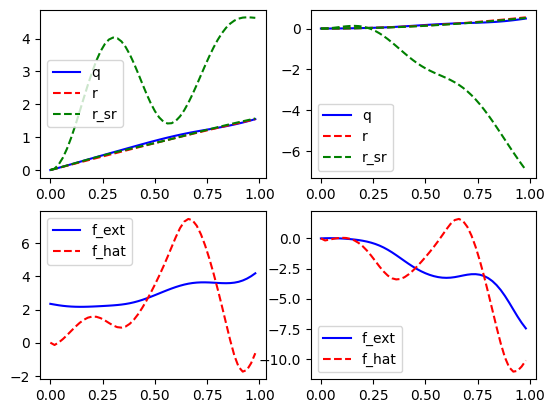

In [ ]:
w = 6.5
T, dt = 1.0, 0.02
ts = jnp.arange(0, T, dt)

# As a comparison, load up 2-norm and see what happens
out_dir_2norm = './train_results/sr_2norm'
file_name_2norm = 'seed=0_M=10.pkl'
params_2norm_sr = direct_load(out_dir_2norm, file_name_2norm, p_norm_flag=False)
sim_2norm_sr = diagnose_simulate(ts, w, params_2norm_sr, reference, NGD_flag=False)
params_2norm = params_2norm_sr.copy()
params_2norm['pnorm'] = convert_p_qbar(2.0)
params_2norm['P'] = 2*jnp.eye(32)
sim_2norm = diagnose_simulate(ts, w, params_2norm, reference, NGD_flag=True)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)
for i in range(2):
    ax[0, i].plot(ts, sim_2norm['q'][:, i], 'b-', label='q')
    ax[0, i].plot(ts, sim_2norm['r'][:, i], 'r--', label='r')
    ax[0, i].plot(ts, sim_2norm_sr['q'][:, i], 'g--', label='r_sr')
    ax[0, i].legend()
    # ax[0, i].set_xlabel('t')
    ax[1, i].plot(ts, sim_2norm['f_ext'][:, i], 'b-', label='f_ext')
    ax[1, i].plot(ts, sim_2norm['f_hat'][:, i], 'r--', label='f_hat')
    ax[0, i].plot(ts, sim_2norm_sr['f_hat'][:, i], 'g--', label='r_sr')
    ax[1, i].legend()

p norm converged to 1.51
5.815508
p norm converged to 2.33
5.78261


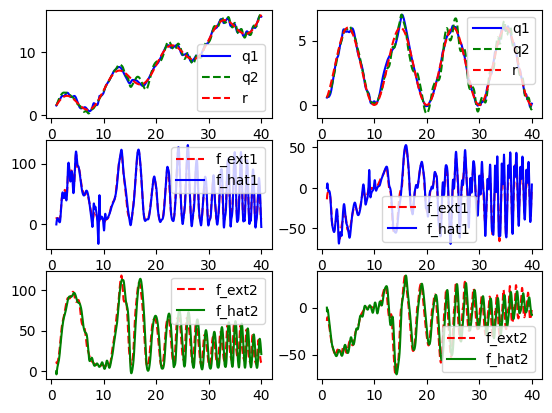

In [ ]:
out_dir = 'train_results/diagnose_training_files'
file_name_1 = 'seed=0_M=2_pinit=1.50_pfreq=50_regP=5.00.pkl'
file_name_2 = 'seed=0_M=10_pinit=2.20_pfreq=100_regP=5.00.pkl'
params_1 = direct_load(out_dir, file_name_1)
params_2 = direct_load(out_dir, file_name_2)

w = 10
T, dt = 40, 0.02
ts = jnp.arange(1.0, T, dt)
sim_1 = diagnose_simulate(ts, w, params_1, reference, NGD_flag=True)
sim_2 = diagnose_simulate(ts, w, params_2, reference, NGD_flag=True)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 2)
for i in range(2):
    ax[0, i].plot(ts, sim_1['q'][:, i], 'b-', label='q1')
    ax[0, i].plot(ts, sim_2['q'][:, i], 'g--', label='q2')
    ax[0, i].plot(ts, sim_1['r'][:, i], 'r--', label='r')
    ax[0, i].legend()
    # ax[0, i].set_xlabel('t')
    ax[1, i].plot(ts, sim_1['f_ext'][:, i], 'r--', label='f_ext1')
    ax[1, i].plot(ts, sim_1['f_hat'][:, i], 'b-', label='f_hat1')
    ax[1, i].legend()
    ax[2, i].plot(ts, sim_2['f_ext'][:, i], 'r--', label='f_ext2')
    ax[2, i].plot(ts, sim_2['f_hat'][:, i], 'g-', label='f_hat2')
    ax[2, i].legend()